# Abstract

The thesis is called "Automated Trading with Reinforcement Learning". The plan is to try various reinforcement learning algorithms, from the more simple to the most complex and see how they adjust and can be modified to better solve the problem. The common denomitor between all of the implementations is the environment(stockMarketenvironment.py, because the Agent will change with the algortihm we are implementing). This environment for now takes closing price for Apple, Tesla and Microsoft for a period of 500 days. We choose a episode lenght(for example now its 200), so each episode the Agent lives each time step from 0 to 200. The observation space, what he sees to take the decision, is a wallet, where he has stored the actions he already bought, and the 90 steps behind the time step he is in. In each step, this information goes to the Agent, and it chooses a number according to it. For example, if we have 3 different stocks that we are following(like Apple, Microsoft and Tesla) and if we can only move 10 actions for each stock max, the Agent will be able to choose a number from 0 to 2*3*10+1=61. If the for example the Agent chooses 50: the action is more then 60/2=30, so it means it is seling. More specifically, we are seeling (51-1-3x10)/10=2(the second stock, Microsoft in this case, of course that when you start training you cant change the numbers of the stocks), and are seeling 51 - 1 - 3 * 10 - 2 * 10 + 1=1 unit. The Agent has some initial cash in this environment, if it sells what it doesn't have or buys when it doesn't have the money for it, it is very penalised. How does the Agent learn to choose the right number is what changes with the algorithm. We started with Deep Q learning, and that is what this code tries to implement, in it's simplest form. The Agent uses the Qnet to be able store the value it learns to give to each decision in each situation. It starts by choosing at random mainly at random(this chance of randomness in the decision is regulated with the gamma parameter), and to record it's experience in the experience buffer organised by episodes. After the experience buffer its full he starts picking random experiences from it and learning with them. We put the training frequency equal to the lenght of the episode so it can learn at the end of every episode, so it can be coerent with it's actions inside an episode. To start to approach this problem at it's simplest form, instead of using the real values of actions we will use never-changing sinusoides, to be sure that the model can learn very simple patterns. You may notice that the neural net I use for this is kind of overkill. I was trying to achieve overfitting, I am not after generalisation yet, I am after this agent's hability to learn the same very simple repetive patterns, but it takes a lot of time to do so, although it definitly does, I find it weird that it takes at least a week of continous training to achieve some results. 

# Imports 

In [1]:
import time
import copy
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from plotly import tools
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot, iplot_mpl
from numpy import random
from math import sin
import matplotlib.pyplot as plt
from math import pi
import gym
from copy import deepcopy
from gym import spaces
import collections

# Create Environment #

### stockMEnv ###

In [2]:
run stockMarketEnvironmentREDUX

In [3]:
env = stockMEnv()
observation = env.reset()
#print(observation)

In [4]:
observation, reward, done, info, cash = env.step(1)
reward

0

In [5]:
observation.shape

(61, 2)

# Creating Q-Table
### Q_Network

In [6]:
class PositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, embed_dim):
        super(PositionEmbedding, self).__init__()
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[1]
        batchS = tf.shape(x)[0]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        positions = tf.expand_dims(positions, axis = 0)
        positions = tf.repeat(positions, batchS, axis=0)
        return x + positions

In [7]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = tf.keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [8]:
def Q_Network(obs_shape,hidden_size,actions_n,head_size=64,num_heads=2,ff_dim=2,num_transformer_blocks=2,dropout=0.4):
    #reshape = tf.keras.layers.Reshape((obs_shape[0]*obs_shape[1]))
    flatten = tf.keras.layers.Flatten()
    dense1 = tf.keras.layers.Dense(units=hidden_size, activation='relu')
    dense2 = tf.keras.layers.Dense(units=hidden_size, activation='relu')
    dense3 = tf.keras.layers.Dense(units=hidden_size, activation='relu')
    dense_action = tf.keras.layers.Dense(units= actions_n, activation='linear')   
    input_model = tf.keras.Input(shape=obs_shape)#pq espaço de obs é 3x90, de ser 90 time steps que olhamos para trás em cada decisão
                                        # não interessa o batch size é como se fosse aplicado a um unico exemplo
    x = input_model
    x = PositionEmbedding(maxlen=env.number_past_steps+1, embed_dim=observation.shape[1])(x)
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    x = flatten(x)
    x = dense1(x)  
    x = dense2(x)
    x = dense3(x)
    action = dense_action(x)
    return tf.keras.Model(inputs=input_model,outputs=action)

Q_net_weights_file = 'Q_weights_REDUX_MW.h5'

hidden_size=100  
loss_function=tf.keras.losses.MeanSquaredError()
opt=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
Q = Q_Network(observation.shape,#env.number_past_steps,
              hidden_size, env.nActions)
#Q.load_weights('/content/google-drive/MyDrive/Tese/Q_weights.h5')
#Q_ast = tf.keras.models.clone_model(Q)
Q_ast = Q_Network(observation.shape,#env.number_past_steps,
              hidden_size, env.nActions) 

In [9]:
Q.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 61, 2)]      0           []                               
                                                                                                  
 position_embedding (PositionEm  (None, 61, 2)       122         ['input_1[0][0]']                
 bedding)                                                                                         
                                                                                                  
 multi_head_attention (MultiHea  (None, 61, 2)       1410        ['position_embedding[0][0]',     
 dAttention)                                                      'position_embedding[0][0]']     
                                                                                              

# Create Experience Buffer
### ExperienceBuffer

In [10]:
Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'new_state'])
class ExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), np.array(next_states)

# Create Agent
## Agent

In [11]:
class Agent:
    def __init__(self, env, exp_buffer):
        self.envs = envs 
        self.numEnvs = len(envs)
        self.render = False
        self.rewards = np.zeros(self.numEnvs)
        self.obs = np.array([env.reset() for env in self.envs]) 
        self.exp_buffer = exp_buffer

    def _reset(self):
        self.obs = np.array([env.reset() for env in self.envs]) 
        self.total_reward = 0.0
        self.render = False

    def play_step(self,epsilon):
        
        if np.random.random() < epsilon:
            actions = []
            for i in range(self.numEnvs):
                actions.append(np.random.randint(env.nActions))
            actions = np.array(actions)
        else:
            batchObservation = self.obs#np.expand_dims(self.obs, 0)
            action = Q.predict(batchObservation)
            actions = []
            for i in range(self.numEnvs):
                actions.append(np.argmax(action[i]))
            
        # do step in the environment
        next_states = self.obs.copy()
        rewards = np.zeros(self.numEnvs)
        for i in range(numEnvs):
            next_states[i], rewards[i], done, cash, _ = envs[i].step(actions[i])
            exp = Experience(self.obs[i], actions[i], rewards[i], done, next_states[i])
            #aqui podemos simplesmente misturar os environments em vez por um elemento do buffer por environment porque o que 
            #interessa para o treino é o par estado-ação que tem toda a info necessária. Assim o buffer fica com as mesmas 
            #dimensões do buffer sem multiple workers, simplesmente ganha mais elementos por step
            self.exp_buffer.append(exp)
        self.obs = next_states
        if done: # done ocorre em simultâneo (neste env) para todos os envs
            if self.render:
                self.envs[0].render()
            self._reset()           
        return rewards,cash,next_states,actions,done

# Training

In [12]:
GAMMA = 0.99
BATCH_SIZE = 64
EPOCH_NUM = 100000
REPLAY_SIZE = 500
EPSILON_START = 0.98
EPSILON_DECREASE = 1e-7
EPSILON_FINAL = 0.04
TRAIN_FREQ = 200 # each episode
UPDATE_Q_FREQ = 200
SHOW_LOG_FREQ = 100
numEnvs =20
envs = [stockMEnv() for i in range(numEnvs)]

In [13]:
buffer = ExperienceBuffer(REPLAY_SIZE)
agent = Agent(envs, buffer)

In [14]:
epsilon = EPSILON_START
total_rewards = []
total_cash = []
total_steps = 0
epoch = 0

In [15]:
def trainQNet(buffer, QNet):
    states, actions, rewards, dones, next_states = buffer.sample(BATCH_SIZE)
    q = Q.predict(states)
    q_ = Q_ast.predict(next_states)# estava aqui Q
    maxq = tf.reduce_max(q_,axis=1)
    target = q.copy()
    for j in range(BATCH_SIZE):
        target[j][actions[j]] = rewards[j]+GAMMA*maxq[j]*(not dones[j])
    with tf.GradientTape() as tape: # estava dentro do for mas dps o target era o antigo
        q_values = Q(states)
        loss = loss_function(target,q_values)
        grads = tape.gradient(loss, Q.trainable_variables)
        opt.apply_gradients(zip(grads, Q.trainable_variables))
        #Q.save_weights(Q_net_weights_file)

In [16]:
def play_demo_episode(env, agent):
    Done = False
    while not Done:
        reward,cash,_,_,Done = agent.play_step(0.0) 

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
100	0.9786280000007221	13720	-352.65191137461994


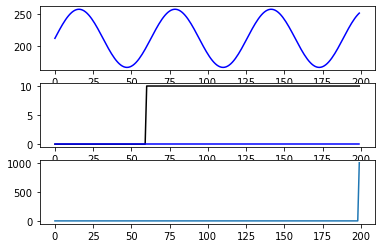

100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 

KeyboardInterrupt: 

In [17]:
# comentar as duas linhas de baixo a primeira vez que se corre
#Q.load_weights(Q_net_weights_file)
#Q_ast.load_weights(Q_net_weights_file)
while EPOCH_NUM>epoch:
    epoch+=1
    print(epoch, end=' ')
    Done=False
    if (epoch+1) % SHOW_LOG_FREQ == 0: # play 1 episode without exploration
        print('\n'+'\t'.join(map(str, [epoch+1, epsilon, total_steps,np.mean(total_rewards)])))
        total_rewards = []
        total_cash = []
        total_steps = 0
        agent.render = True
        play_demo_episode(env, agent)
        agent.render = False
        continue

    while not Done:
        total_steps +=1
        if epsilon>EPSILON_FINAL:
            epsilon-=EPSILON_DECREASE
        reward,cash,_,_,Done = agent.play_step(epsilon)
        if Done:
            total_rewards.append(reward)
            #total_cash.append(cash)
        if len(buffer) < REPLAY_SIZE:
            continue
        if total_steps % TRAIN_FREQ == 0:
            trainQNet(buffer, Q)
        if total_steps % UPDATE_Q_FREQ == 0:
            Q.save_weights(Q_net_weights_file)
            #Q_ast.set_weights(Q.get_weights())
            Q_ast.load_weights(Q_net_weights_file)
